In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

I had some difficulties uninstalling pytorch without cuda to replace it so I just created another virtual env and ran it in that. (I think this only needs to be done when you try to run it local)

After activating the venv you can install the pytorch with cuda with the following command.

`pip3 install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html`


In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [33]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [34]:
train_csv = pd.read_csv("../data/fashion-mnist_train.csv")
test_csv = pd.read_csv("../data/fashion-mnist_test.csv")

In [35]:
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [36]:
# Transform data into Tensor that has a range from 0 to 1
train_set = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(train_set, batch_size=100)

All the above has been done to load data in batches into the model. We use the DataLoader class from torch.utils.data. We also initialize the device to be used as the GPU instead of CPU.

The FashionDataset class has two methods: 
- get_item(index) -> image and label of item at index
- len() -> number of items in the dataset

In [37]:
# Mapping label number to a more meaningful label

def output_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat", 
        5: "Sandal", 
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot"
    }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

2


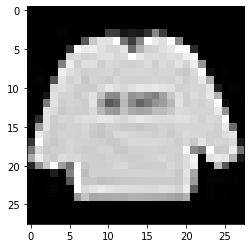

In [38]:
# displaying image using matplotlib imshow()
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [39]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  Pullover, Ankle Boot, Shirt, T-shirt/Top, Dress, Coat, Coat, Sandal, Coat, Bag, 

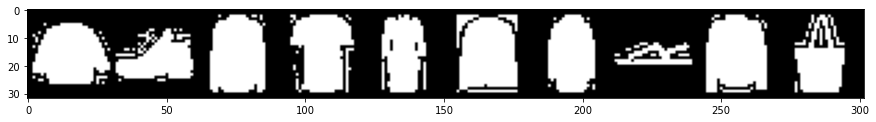

In [40]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

1. Make a model class (inherits nn.Module class)
2. Add Layers to model class

    a. Convolution layer with kernel size 3*3, padding = 1 (no padding) in 1st layer and padding = 0 in second layer. Stride of 1 in both layers.

    b. Batch normalization layer

    c. Activation function used: ReLU

    d. Max Pooling layer with kernel size of 2 * 2 and stride 2.

        i. flatten out output for dense layer

        ii. 3 fully connected layers with different in/out features

        iii. 1 dropout layer with p=0.25

Summary is as follows:

First conv layer -> Max Pooling layer -> Second conv layer -> second max pooling layer

28 * 28 * 3      --> 28 * 28 * 32      --> 14 * 14 * 32      --> 12 * 12 * 64              --> 6 * 6 * 64

Final fully connected layer has 10 output features for 10 types of clothes.

In [41]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [42]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [43]:
# Training and Testing
num_epochs = 10 # num of epochs can also be increased > 100
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28)) # Apparently Variable is outdated so maybe we should change it
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.49817562103271484, Accuracy: 87.41166687011719%
Iteration: 1000, Loss: 0.31753814220428467, Accuracy: 89.74166870117188%
Iteration: 1500, Loss: 0.21549388766288757, Accuracy: 90.81666564941406%
Iteration: 2000, Loss: 0.2227795422077179, Accuracy: 91.70999908447266%
Iteration: 2500, Loss: 0.21930934488773346, Accuracy: 92.86333465576172%
Iteration: 3000, Loss: 0.18449829518795013, Accuracy: 93.11333465576172%
Iteration: 3500, Loss: 0.3319951593875885, Accuracy: 93.1433334350586%
Iteration: 4000, Loss: 0.19257867336273193, Accuracy: 92.41999816894531%
Iteration: 4500, Loss: 0.15338116884231567, Accuracy: 93.09833526611328%
Iteration: 5000, Loss: 0.13561643660068512, Accuracy: 94.29499816894531%
Iteration: 5500, Loss: 0.13708768784999847, Accuracy: 94.15166473388672%
Iteration: 6000, Loss: 0.13327981531620026, Accuracy: 94.74833679199219%


Visualizing the results

In [44]:
print(iteration_list)
print(loss_list)

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900, 2950, 3000, 3050, 3100, 3150, 3200, 3250, 3300, 3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800, 3850, 3900, 3950, 4000, 4050, 4100, 4150, 4200, 4250, 4300, 4350, 4400, 4450, 4500, 4550, 4600, 4650, 4700, 4750, 4800, 4850, 4900, 4950, 5000, 5050, 5100, 5150, 5200, 5250, 5300, 5350, 5400, 5450, 5500, 5550, 5600, 5650, 5700, 5750, 5800, 5850, 5900, 5950, 6000]
[tensor(0.4466, device='cuda:0'), tensor(0.4428, device='cuda:0'), tensor(0.6337, device='cuda:0'), tensor(0.3743, device='cuda:0'), tensor(0.5723, device='cuda:0'), tensor(0.3216, device='cuda:0'), tensor(0.3145, device='cuda:0'), tensor(0.4260, device='cuda:0'), tensor(0.4979, device='cuda:0'), t

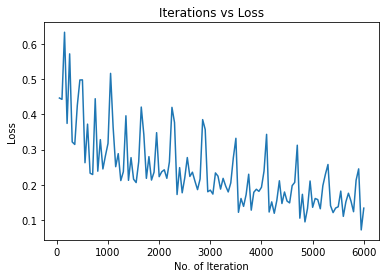

In [45]:
plt.plot(iteration_list, [x.cpu() for x in loss_list])
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

From the graph we can see a downward trend of loss vs iteration. Perhaps a reason for the spikes in loss could be just due to the randomness of the batch sampling. An unlucky sampling could have led to the loss increasing compared to the previous iterations but overall the loss has a downward trend as iterations increase.

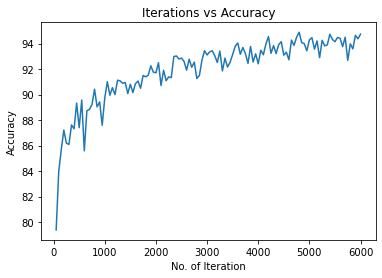

In [46]:
plt.plot(iteration_list, [x.cpu() for x in accuracy_list])
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [47]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 90.00%
Accuracy of Trouser: 99.50%
Accuracy of Pullover: 90.30%
Accuracy of Dress: 97.18%
Accuracy of Coat: 97.72%
Accuracy of Sandal: 99.57%
Accuracy of Shirt: 77.37%
Accuracy of Sneaker: 97.02%
Accuracy of Bag: 99.62%
Accuracy of Ankle Boot: 99.17%


In [48]:
from itertools import chain
import sklearn.metrics as metrics

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.87      0.88      0.87    720000
           1       0.99      0.99      0.99    720000
           2       0.87      0.89      0.88    720000
           3       0.91      0.93      0.92    720000
           4       0.87      0.86      0.87    720000
           5       0.98      0.98      0.98    720000
           6       0.80      0.76      0.78    720000
           7       0.96      0.96      0.96    720000
           8       0.98      0.99      0.98    720000
           9       0.97      0.97      0.97    720000

    accuracy                           0.92   7200000
   macro avg       0.92      0.92      0.92   7200000
weighted avg       0.92      0.92      0.92   7200000




In [49]:
torch.__version__

'1.9.1+cu111'